<summary>Table of Contents</summary>

- [1. Input length](#1-input-length)
- [2. Comparison of models](#2-comparison-of-models)
- [3. Self-supervised](#3-self-supervised)
- [4. Ablation study](#4-ablation-study)
    - [4.1. W/o RevIN](#41-wo-revin)
    - [4.2 W/o channel independence](#42-wo-channel-independence-channel-mixing)
    - [4.3 W/o patching](#43-wo-patching)
- [5. TimeLLM](#5-timellm)
- [6. Decomposition](#6-decomposition)

This script summarizes results from all experiments and represents them in plots and tables.

In [35]:
import pandas as pd
import os
from utils.helper import style_dataframe, \
                         map_country_name, \
                         read_results_csv, \
                         choose_best_model, \
                         calculate_improvement
                         
from utils.plot_final_results import plot_results_models_multiple_countries


# 1. Input length

In [36]:
patchtst_df = read_results_csv('patchtst/patchtst_128.csv',
                               columns_to_extract = ('PatchTST/42', ['RMSE', 'MAE'])
                               )
patchtst_21_df = read_results_csv('patchtst/patchtst_168_21_patch.csv',
                                   columns_to_extract = ('PatchTST/21', ['RMSE', 'MAE'])
                                   )
patchtst_64_df = read_results_csv('patchtst/patchtst_bs128_pl512.csv',
                                   columns_to_extract = ('PatchTST/64', ['RMSE', 'MAE'])
                                   )

all_df_store = pd.concat([patchtst_21_df, patchtst_df, patchtst_64_df], axis=1)

# Change country codes to country names
level_names = all_df_store.index.names
all_df_store.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df_store.index],
    names=level_names
)
# Scale
scale = 10**2
all_df_scale_store = all_df_store * scale

# With best PatchTST configurations
result_df_unscaled = choose_best_model(all_df_store,
                                       'PatchTST')
result_df = result_df_unscaled * scale

# Highlight the minimal values in bold
styled_df = style_dataframe(all_df_scale_store, decimal_places=2)
styled_df


In [37]:
best_vs_base = pd.concat([result_df, all_df_scale_store.loc[:, all_df_store.columns.get_level_values('Model') == 'PatchTST/42']], axis=1)
best_vs_base = calculate_improvement(best_vs_base, 
                                      base_mae_model='PatchTST', 
                                      model_to_compare_mae='PatchTST/42',
                                      grouped_by_models=False)
print(f"Average improvement of MAE: {(best_vs_base.loc[best_vs_base['mae_improvement']!=0]['mae_improvement'].mean()).round(2)} %.")
print(f"Average improvement of RMSE: {(best_vs_base.loc[best_vs_base['rmse_improvement']!=0]['rmse_improvement'].mean()).round(2)} %.")

Average improvement of MAE: 1.71 %.
Average improvement of RMSE: 1.42 %.


In [38]:
# Save styled dataframe to HTML
path = './stored_elements/tables'

if not os.path.exists(path):
    os.makedirs(path)
styled_df.to_html(os.path.join(path, 'patchtst_input_length_10_power_2.html'), index=True)

# 2. Comparison of models

In [39]:
# Read data
naive_df = read_results_csv('naive/metrics_persistence_countries_minmax.csv',
                            columns_to_extract = ('Persistence', ['RMSE', 'MAE'])
                            )
arima_df = read_results_csv('arima/metrics_arima_countries_minmax.csv',
                             columns_to_extract = ('(S)ARIMA', ['RMSE', 'MAE'])
                             )
informer_df = read_results_csv('informer/informer.csv',
                               columns_to_extract = ('Informer', ['RMSE', 'MAE'])
                               )

# Concat all dfs with default PatchTST
all_df = pd.concat([informer_df, arima_df, naive_df], axis=1)

# Scale
scale = 10**2

# Change country codes to country names
level_names = all_df.index.names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index], 
    names=level_names
)
all_df_scale = all_df * scale

# Concat all dfs with best PatchTST - FINAL TABLE
all_df_with_result = pd.concat(
    [result_df, all_df_scale],
    axis=1
)

unscaled_for_plots = all_df_with_result / scale

all_df_with_result.columns.names = ['Model', 'Metrics']

# Highlight the minimal values in bold.
styled_df = style_dataframe(all_df_with_result, decimal_places=2, second_value=True)
styled_df

In [40]:
# Save styled dataframe to HTML
path = './stored_elements/tables'

if not os.path.exists(path):
    os.makedirs(path)
styled_df.to_html(os.path.join(path, 'patchtst_baselines_10_power_2.html'), index=True)

In [41]:
# Absolute difference between MAE and RMSE
maes = all_df_with_result.loc[:, (slice(None), 'MAE')].droplevel('Metrics', axis=1)
rmses = all_df_with_result.loc[:, (slice(None), 'RMSE')].droplevel('Metrics', axis=1)
(maes - rmses).round(2)

Model                    PatchTST  Informer  (S)ARIMA  Persistence
Country        Pred_len                                           
Germany        24           -5.32     -5.34     -1.83        -5.74
               96           -5.79     -5.71     -3.79        -6.45
               168          -5.73     -6.03     -4.27        -6.38
United Kingdom 24           -5.38     -5.61     -2.39        -5.44
               96           -5.93     -6.49     -3.84        -6.12
               168          -5.96     -7.62     -4.39        -6.14
Spain          24           -3.79     -6.98     -1.79        -4.63
               96           -4.69     -7.50     -2.95        -5.75
               168          -4.73     -7.30     -4.02        -5.36
France         24           -4.31     -4.54     -1.55        -4.24
               96           -5.42     -5.60     -2.74        -5.32
               168          -5.39     -5.60     -3.39        -5.48
Italy          24           -4.13     -4.07     -1.67        -4.73
               96           -5.18     -4.53     -2.79        -5.61
               168          -5.17     -4.78     -3.81        -4.77

In [42]:
informer_improvement = all_df_with_result.copy()
informer_improvement = calculate_improvement(informer_improvement, 
                      base_mae_model='PatchTST', 
                      model_to_compare_mae='Informer',
                      grouped_by_models=False).round(2)
informer_improvement

Model                   PatchTST        Informer        (S)ARIMA         \
Metrics                     RMSE    MAE     RMSE    MAE     RMSE    MAE   
Country        Pred_len                                                   
Germany        24          14.43   9.11    15.97  10.63    11.15   9.32   
               96          18.61  12.82    20.39  14.68    20.28  16.49   
               168         19.27  13.54    21.42  15.39    22.79  18.51   
United Kingdom 24          15.65  10.27    17.64  12.03    14.41  12.01   
               96          20.02  14.09    22.50  16.01    21.53  17.69   
               168         20.62  14.66    25.91  18.29    22.67  18.28   
Spain          24           9.87   6.07    17.42  10.45     9.68   7.89   
               96          13.49   8.79    21.24  13.74    14.17  11.22   
               168         14.21   9.48    21.38  14.08    17.61  13.59   
France         24           9.97   5.66    11.71   7.17     7.60   6.06   
               96          13.63   8.20    14.80   9.20    12.54   9.81   
               168         14.26   8.86    15.14   9.53    14.89  11.50   
Italy          24           9.95   5.82    10.67   6.60     8.64   6.98   
               96          13.15   7.98    13.70   9.16    13.12  10.33   
               168         13.75   8.58    14.53   9.75    16.57  12.76   

Model                   Persistence        rmse_improvement mae_improvement  
Metrics                        RMSE    MAE                                   
Country        Pred_len                                                      
Germany        24             19.61  13.87             9.64           14.32  
               96             26.14  19.69             8.74           12.67  
               168            23.39  17.01            10.06           12.03  
United Kingdom 24             19.89  14.45            11.31           14.64  
               96             25.54  19.42            11.02           11.95  
               168            24.69  18.56            20.43           19.88  
Spain          24             14.06   9.43            43.38           41.88  
               96             19.67  13.92            36.49           35.98  
               168            17.74  12.38            33.52           32.68  
France         24             12.24   8.00            14.86           21.00  
               96             17.82  12.50             7.94           10.86  
               168            16.29  10.81             5.82            7.06  
Italy          24             14.40   9.66             6.77           11.81  
               96             19.71  14.10             3.98           12.98  
               168            15.69  10.92             5.34           11.98

In [43]:
informer_improvement['mae_improvement'].groupby('Country').mean()

Country
France            12.973333
Germany           13.006667
Italy             12.256667
Spain             36.846667
United Kingdom    15.490000
Name: mae_improvement, dtype: float64

In [44]:
informer_improvement['rmse_improvement'].groupby('Country').mean()

Country
France             9.540000
Germany            9.480000
Italy              5.363333
Spain             37.796667
United Kingdom    14.253333
Name: rmse_improvement, dtype: float64

In [45]:
print(f"Average improvement of MAE: {(informer_improvement.loc[informer_improvement['mae_improvement']!=0]['mae_improvement'].mean()).round(2)} %.")
print(f"Average improvement of RMSE: {(informer_improvement.loc[informer_improvement['rmse_improvement']!=0]['rmse_improvement'].mean()).round(2)} %.")

Average improvement of MAE: 18.11 %.
Average improvement of RMSE: 15.29 %.


In [46]:
second_best_improvement = all_df_with_result.copy()
second_best_improvement = calculate_improvement(second_best_improvement, 
                      base_mae_model='PatchTST', 
                      grouped_by_models=False).round(2)
second_best_improvement
                                                    

Model                   PatchTST        Informer        (S)ARIMA         \
Metrics                     RMSE    MAE     RMSE    MAE     RMSE    MAE   
Country        Pred_len                                                   
Germany        24          14.43   9.11    15.97  10.63    11.15   9.32   
               96          18.61  12.82    20.39  14.68    20.28  16.49   
               168         19.27  13.54    21.42  15.39    22.79  18.51   
United Kingdom 24          15.65  10.27    17.64  12.03    14.41  12.01   
               96          20.02  14.09    22.50  16.01    21.53  17.69   
               168         20.62  14.66    25.91  18.29    22.67  18.28   
Spain          24           9.87   6.07    17.42  10.45     9.68   7.89   
               96          13.49   8.79    21.24  13.74    14.17  11.22   
               168         14.21   9.48    21.38  14.08    17.61  13.59   
France         24           9.97   5.66    11.71   7.17     7.60   6.06   
               96          13.63   8.20    14.80   9.20    12.54   9.81   
               168         14.26   8.86    15.14   9.53    14.89  11.50   
Italy          24           9.95   5.82    10.67   6.60     8.64   6.98   
               96          13.15   7.98    13.70   9.16    13.12  10.33   
               168         13.75   8.58    14.53   9.75    16.57  12.76   

Model                   Persistence        improvement_rmse improvement_mae  
Metrics                        RMSE    MAE                                   
Country        Pred_len                                                      
Germany        24             19.61  13.87             0.00            2.26  
               96             26.14  19.69             8.26           12.67  
               168            23.39  17.01            10.06           12.03  
United Kingdom 24             19.89  14.45             0.00           14.53  
               96             25.54  19.42             7.00           11.95  
               168            24.69  18.56             9.04           19.83  
Spain          24             14.06   9.43             0.00           23.02  
               96             19.67  13.92             4.82           21.61  
               168            17.74  12.38            19.31           23.45  
France         24             12.24   8.00             0.00            6.48  
               96             17.82  12.50             0.00           10.86  
               168            16.29  10.81             4.26            7.06  
Italy          24             14.40   9.66             0.00           11.81  
               96             19.71  14.10             0.00           12.98  
               168            15.69  10.92             5.34           11.98

In [47]:
print(f"Average improvement of MAE: {(second_best_improvement.loc[second_best_improvement['improvement_mae']!=0]['improvement_mae'].mean()).round(2)} %.")
print(f"Average improvement of RMSE: {(second_best_improvement.loc[second_best_improvement['improvement_rmse']!=0]['improvement_rmse'].mean()).round(2)} %.")

Average improvement of MAE: 13.5 %.
Average improvement of RMSE: 8.51 %.


In [48]:
second_best_improvement['improvement_mae'].groupby('Country').mean()

Country
France             8.133333
Germany            8.986667
Italy             12.256667
Spain             22.693333
United Kingdom    15.436667
Name: improvement_mae, dtype: float64

In [49]:
second_best_improvement['improvement_rmse'].groupby('Country').mean()

Country
France            1.420000
Germany           6.106667
Italy             1.780000
Spain             8.043333
United Kingdom    5.346667
Name: improvement_rmse, dtype: float64

In [50]:
second_best_improvement['improvement_mae'].groupby('Pred_len').mean()

Pred_len
24     11.620
96     14.014
168    14.870
Name: improvement_mae, dtype: float64

Create plots.

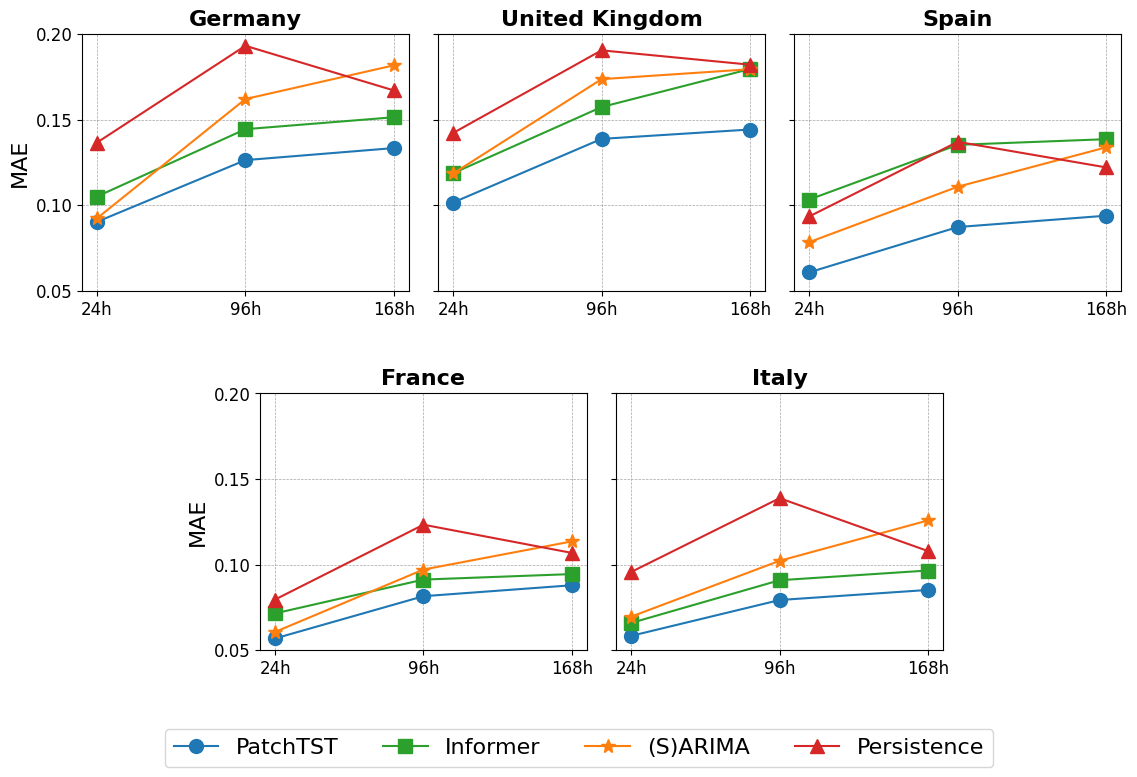

In [51]:
plot_results_models_multiple_countries(unscaled_for_plots, 
                                       function="lines", 
                                       eval_metric='MAE',
                                       decimal_places=2
                                       )

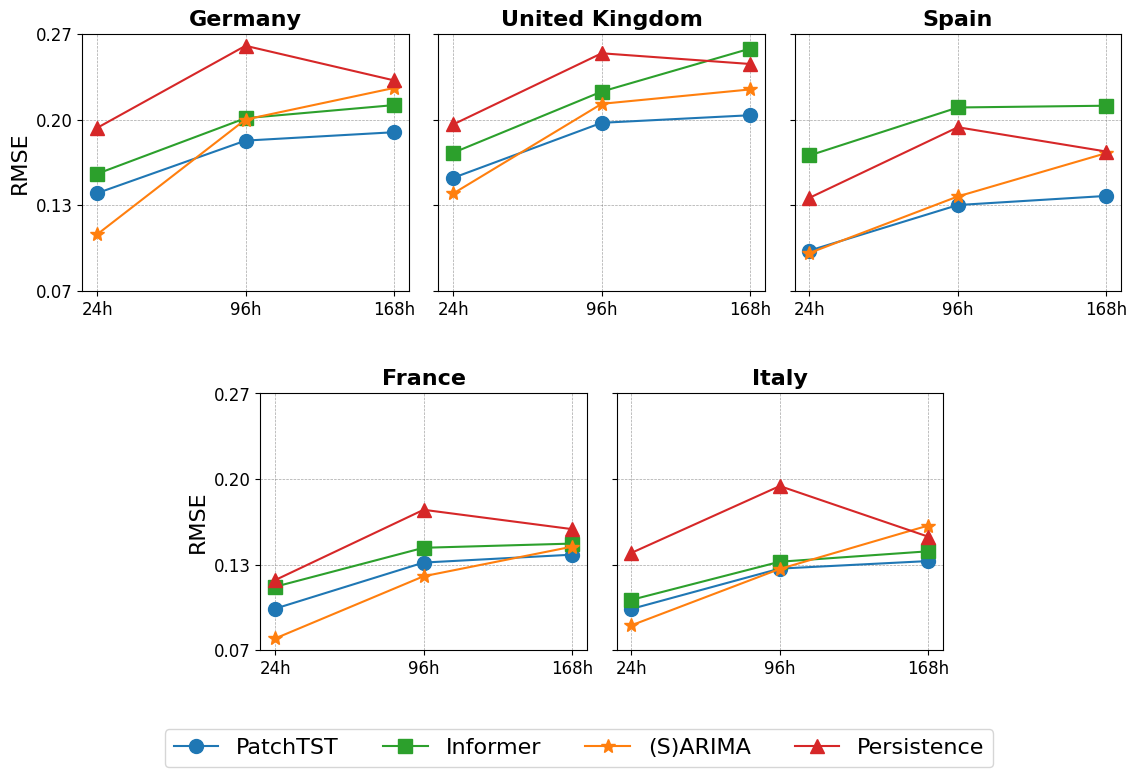

In [52]:
plot_results_models_multiple_countries(unscaled_for_plots, 
                                       function="lines", 
                                       eval_metric='RMSE',
                                       decimal_places=2)

# 3. Self-supervised

In [53]:
# Read data
self_sup = read_results_csv('patchtst/finetune_results.csv',
                                    columns_to_extract = ('Self-supervised', ['RMSE', 'MAE'])
                                    )
self_supervised = self_sup.copy()
# Change country codes to country names
self_supervised.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in self_supervised.index],
    names=level_names
)

all_df = pd.concat([self_supervised, result_df_unscaled], axis=1)

# Scale
all_df_scale = all_df * scale

# Highlight the minimal values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [54]:
styled_df.to_html(os.path.join(path, 'self_supervised_10_power_2.html'), index=True)

# 4. Ablation study

In [55]:
# Read data
no_revin = read_results_csv('patchtst/patchtst_no_revin.csv', 
                           columns_to_extract = ('-RevIN', ['RMSE', 'MAE'])
                           )
patchtst_mix_features = read_results_csv('patchtst/patchtst_channel_mixing_MIX_FEATURES.csv',
                                        columns_to_extract = ('CM', ['RMSE', 'MAE'])
                                        )

patchtst_mix_corr = read_results_csv('patchtst/channel_mixing_new.csv',
                                        columns_to_extract = ('CM', ['RMSE', 'MAE'])
                                        )
no_patch = read_results_csv('patchtst/patchtst_no_patching.csv', 
                           columns_to_extract = ('-P', ['RMSE', 'MAE'])
                           )

all_df = pd.concat([no_revin, patchtst_mix_features, no_patch], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

all_df = pd.concat([result_df_unscaled, all_df], axis=1)

# Scale
all_df_scale = all_df * scale

# Highlight maximum values in bold
styled_df = style_dataframe(all_df_scale, 'max', decimal_places=2)
styled_df

In [56]:
# Calculate difference
models = ['-RevIN', 'CM', '-P']
metrics = ['RMSE', 'MAE']

results = {}
for model in models:
    for metric in metrics:
        results[(model, metric)] = all_df.loc[:, (model, metric)] - all_df.loc[:, ('PatchTST', metric)]

diff_df = pd.DataFrame(results)
level_names = all_df.index.names
diff_df.columns = pd.MultiIndex.from_tuples(diff_df.columns, names=all_df.columns.names)

# Rename for plot
rename_map = {'-RevIN': 'w/o RevIN', 'CM': 'CM', '-P': 'w/o Patching'}
new_columns = diff_df.columns.to_frame(index=False)
new_columns['Model'] = new_columns['Model'].replace(rename_map)
diff_df.columns = pd.MultiIndex.from_frame(new_columns)
diff_df.round(4)

Model                   w/o RevIN              CM         w/o Patching        
Metrics                      RMSE     MAE    RMSE     MAE         RMSE     MAE
Country        Pred_len                                                       
Germany        24          0.0034  0.0041  0.0153  0.0150       0.0037  0.0039
               96          0.0045  0.0024  0.0093  0.0102       0.0022  0.0035
               168         0.0048  0.0019  0.0074  0.0074       0.0012  0.0011
United Kingdom 24          0.0067  0.0069  0.0126  0.0148       0.0039  0.0030
               96          0.0012  0.0021  0.0067  0.0062       0.0006  0.0006
               168         0.0133  0.0091  0.0059  0.0055       0.0013  0.0004
Spain          24          0.0368  0.0234  0.0081  0.0085       0.0041  0.0041
               96          0.0412  0.0263  0.0088  0.0086       0.0039  0.0043
               168         0.0393  0.0264  0.0092  0.0085       0.0042  0.0033
France         24          0.0051  0.0074  0.0052  0.0044       0.0045  0.0033
               96          0.0029  0.0053  0.0020  0.0029       0.0052  0.0037
               168         0.0039  0.0043 -0.0013  0.0003       0.0057  0.0025
Italy          24          0.0048  0.0076  0.0038  0.0038       0.0018  0.0025
               96          0.0022  0.0062  0.0057  0.0062       0.0038  0.0034
               168         0.0000  0.0039  0.0033  0.0044       0.0019  0.0019

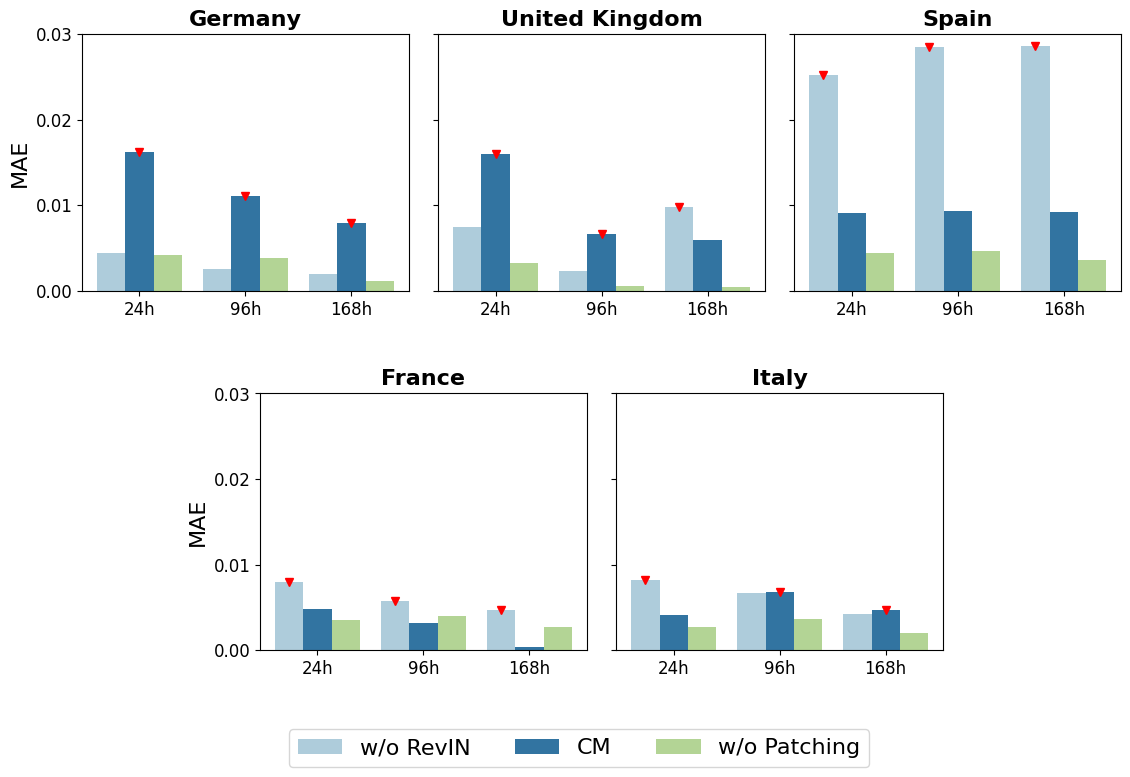

In [57]:
plot_results_models_multiple_countries(diff_df, 
                                       function="bars", 
                                       eval_metric='MAE',
                                       palette="Paired",
                                       plot_max_markers=True,
                                       decimal_places=2)

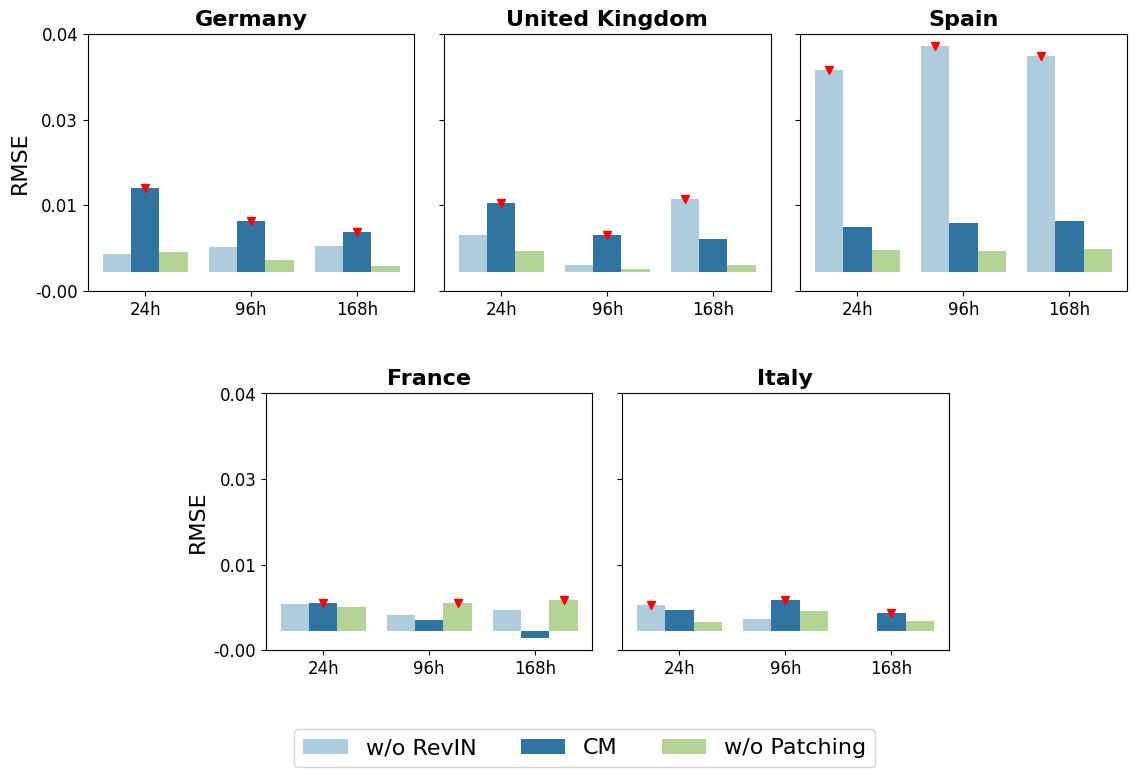

In [58]:
plot_results_models_multiple_countries(diff_df, 
                                       function="bars", 
                                       eval_metric='RMSE',
                                       palette="Paired",
                                       plot_max_markers=True,
                                       decimal_places=2)

## 4.1. W/o RevIN

In [59]:
no_revin.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in no_revin.index],
    names=level_names
)

revin = pd.concat([result_df_unscaled, no_revin], axis=1)

# Scale
revin = revin * scale

revin['rmse_improvement'] = (revin.loc[:, ('-RevIN', 'RMSE')] - (revin.loc[:, ('PatchTST', 'RMSE')]))
revin['mae_improvement'] = (revin.loc[:, ('-RevIN', 'MAE')] - revin.loc[:, ('PatchTST', 'MAE')])
revin.round(2)

Model                   PatchTST        -RevIN        rmse_improvement  \
Metrics                     RMSE    MAE   RMSE    MAE                    
Country        Pred_len                                                  
Germany        24          14.43   9.11  14.77   9.52             0.34   
               96          18.61  12.82  19.06  13.06             0.45   
               168         19.27  13.54  19.75  13.73             0.48   
United Kingdom 24          15.65  10.27  16.31  10.95             0.67   
               96          20.02  14.09  20.14  14.31             0.12   
               168         20.62  14.66  21.95  15.56             1.33   
Spain          24           9.87   6.07  13.55   8.41             3.68   
               96          13.49   8.79  17.61  11.43             4.12   
               168         14.21   9.48  18.14  12.12             3.93   
France         24           9.97   5.66  10.48   6.40             0.51   
               96          13.63   8.20  13.92   8.73             0.29   
               168         14.26   8.86  14.65   9.29             0.39   
Italy          24           9.95   5.82  10.42   6.58             0.48   
               96          13.15   7.98  13.37   8.60             0.22   
               168         13.75   8.58  13.75   8.97             0.00   

Model                   mae_improvement  
Metrics                                  
Country        Pred_len                  
Germany        24                  0.41  
               96                  0.24  
               168                 0.19  
United Kingdom 24                  0.69  
               96                  0.21  
               168                 0.91  
Spain          24                  2.34  
               96                  2.63  
               168                 2.64  
France         24                  0.74  
               96                  0.53  
               168                 0.43  
Italy          24                  0.76  
               96                  0.62  
               168                 0.39

In [60]:
decimal_places = 2
format_string = f"{{:.{decimal_places}f}}"
styled_df = revin.style.format(format_string)
styled_df.to_html(os.path.join(path, 'no_revin_10_power_2.html'), index=True)

In [61]:
revin = calculate_improvement(revin, 
                      base_mae_model='-RevIN', 
                      model_to_compare_mae='PatchTST',
                      grouped_by_models=False).round(2)
print(f"Average reduction of MAE: {(revin.loc[revin['mae_improvement']!=0]['mae_improvement'].mean()).round(1)} %.")
print(f"Average reduction of RMSE: {(revin.loc[revin['rmse_improvement']!=0]['rmse_improvement'].mean()).round(1)} %.")

Average reduction of MAE: -11.2 %.
Average reduction of RMSE: -8.7 %.


In [70]:
revin.groupby('Country').mean().round(1)

Model          PatchTST       -RevIN       rmse_improvement mae_improvement
Metrics            RMSE   MAE   RMSE   MAE                                 
Country                                                                    
France             12.6   7.6   13.0   8.1             -3.3            -8.1
Germany            17.4  11.8   17.9  12.1             -2.4            -2.6
Italy              12.3   7.5   12.5   8.0             -2.2            -8.4
Spain              12.5   8.1   16.4  10.7            -31.9           -32.1
United Kingdom     18.8  13.0   19.5  13.6             -3.8            -4.8

## 4.2. W/o channel independence (channel-mixing)

In [29]:
patchtst_mix_features.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in patchtst_mix_features.index],
    names=level_names
)

patchtst_mix_features = pd.concat([result_df_unscaled, patchtst_mix_features], axis=1)

# Scale
patchtst_mix_features = patchtst_mix_features * scale

patchtst_mix_features['rmse_improvement'] = (patchtst_mix_features.loc[:, ('CM', 'RMSE')] - patchtst_mix_features.loc[:, ('PatchTST', 'RMSE')]) 
patchtst_mix_features['mae_improvement'] = (patchtst_mix_features.loc[:, ('CM', 'MAE')] - patchtst_mix_features.loc[:, ('PatchTST', 'MAE')]) 
patchtst_mix_features.round(2)

Model                   PatchTST            CM        rmse_improvement  \
Metrics                     RMSE    MAE   RMSE    MAE                    
Country        Pred_len                                                  
Germany        24          14.43   9.11  15.96  10.60             1.53   
               96          18.61  12.82  19.53  13.84             0.93   
               168         19.27  13.54  20.01  14.28             0.74   
United Kingdom 24          15.65  10.27  16.91  11.75             1.26   
               96          20.02  14.09  20.69  14.71             0.67   
               168         20.62  14.66  21.21  15.20             0.59   
Spain          24           9.87   6.07  10.68   6.92             0.81   
               96          13.49   8.79  14.37   9.65             0.88   
               168         14.21   9.48  15.14  10.32             0.92   
France         24           9.97   5.66  10.49   6.11             0.52   
               96          13.63   8.20  13.83   8.49             0.20   
               168         14.26   8.86  14.13   8.89            -0.13   
Italy          24           9.95   5.82  10.33   6.20             0.38   
               96          13.15   7.98  13.72   8.60             0.57   
               168         13.75   8.58  14.08   9.02             0.33   

Model                   mae_improvement  
Metrics                                  
Country        Pred_len                  
Germany        24                  1.50  
               96                  1.02  
               168                 0.74  
United Kingdom 24                  1.48  
               96                  0.62  
               168                 0.55  
Spain          24                  0.85  
               96                  0.86  
               168                 0.85  
France         24                  0.44  
               96                  0.29  
               168                 0.03  
Italy          24                  0.38  
               96                  0.62  
               168                 0.44

In [30]:
decimal_places = 2
format_string = f"{{:.{decimal_places}f}}"
styled_df = patchtst_mix_features.style.format(format_string)
styled_df.to_html(os.path.join(path, 'cm_10_power_2.html'), index=True)

In [31]:
patchtst_mix_features = calculate_improvement(patchtst_mix_features, 
                                              base_mae_model='CM', 
                                              model_to_compare_mae='PatchTST',
                                              grouped_by_models=False).round(2)
print(f"Average reduction of MAE: {(patchtst_mix_features.loc[patchtst_mix_features['mae_improvement']!=0]['mae_improvement'].mean()).round(1)} %.")
print(f"Average reduction of RMSE: {(patchtst_mix_features.loc[patchtst_mix_features['rmse_improvement']!=0]['rmse_improvement'].mean()).round(1)} %.")

Average reduction of MAE: -7.7 %.
Average reduction of RMSE: -4.8 %.


In [52]:
patchtst_mix_corr.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in patchtst_mix_corr.index],
    names=level_names
)

patchtst_mix_corr = pd.concat([result_df_unscaled, patchtst_mix_corr], axis=1)

# Scale
patchtst_mix_corr = patchtst_mix_corr * scale

patchtst_mix_corr['rmse_improvement'] = (patchtst_mix_corr.loc[:, ('CM', 'RMSE')] - patchtst_mix_corr.loc[:, ('PatchTST', 'RMSE')]) 
patchtst_mix_corr['mae_improvement'] = (patchtst_mix_corr.loc[:, ('CM', 'MAE')] - patchtst_mix_corr.loc[:, ('PatchTST', 'MAE')]) 
patchtst_mix_corr.round(2)

Model                   PatchTST            CM        rmse_improvement  \
Metrics                     RMSE    MAE   RMSE    MAE                    
Country        Pred_len                                                  
Germany        24          14.43   9.11  15.29  10.06             0.86   
               96          18.61  12.82  19.53  13.84             0.93   
               168         19.27  13.54  20.01  14.28             0.74   
United Kingdom 24          15.65  10.27  16.30  10.94             0.65   
               96          20.02  14.09  20.69  14.71             0.67   
               168         20.62  14.66  21.21  15.20             0.59   
Spain          24           9.87   6.07  10.68   6.92             0.81   
               96          13.49   8.79  14.37   9.65             0.88   
               168         14.21   9.48  15.14  10.32             0.92   
France         24           9.97   5.66  10.49   6.11             0.52   
               96          13.63   8.20  13.83   8.49             0.20   
               168         14.26   8.86  14.13   8.89            -0.13   
Italy          24           9.95   5.82  10.33   6.20             0.38   
               96          13.15   7.98  13.72   8.60             0.57   
               168         13.75   8.58  14.08   9.02             0.33   

Model                   mae_improvement  
Metrics                                  
Country        Pred_len                  
Germany        24                  0.95  
               96                  1.02  
               168                 0.74  
United Kingdom 24                  0.68  
               96                  0.62  
               168                 0.55  
Spain          24                  0.85  
               96                  0.86  
               168                 0.85  
France         24                  0.44  
               96                  0.29  
               168                 0.03  
Italy          24                  0.38  
               96                  0.62  
               168                 0.44

## 4.3. W/o patching

In [32]:
no_patch.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in no_patch.index],
    names=level_names
)

no_patch = pd.concat([result_df_unscaled, no_patch], axis=1)

# Scale
no_patch = no_patch * scale

no_patch['rmse_improvement'] = (no_patch.loc[:, ('-P', 'RMSE')] - no_patch.loc[:, ('PatchTST', 'RMSE')]) 
no_patch['mae_improvement'] = (no_patch.loc[:, ('-P', 'MAE')] - no_patch.loc[:, ('PatchTST', 'MAE')]) 
no_patch.round(2)

Model                   PatchTST            -P        rmse_improvement  \
Metrics                     RMSE    MAE   RMSE    MAE                    
Country        Pred_len                                                  
Germany        24          14.43   9.11  14.80   9.50             0.37   
               96          18.61  12.82  18.82  13.17             0.22   
               168         19.27  13.54  19.39  13.65             0.12   
United Kingdom 24          15.65  10.27  16.04  10.57             0.39   
               96          20.02  14.09  20.07  14.15             0.06   
               168         20.62  14.66  20.75  14.70             0.13   
Spain          24           9.87   6.07  10.27   6.48             0.41   
               96          13.49   8.79  13.88   9.23             0.39   
               168         14.21   9.48  14.63   9.81             0.42   
France         24           9.97   5.66  10.42   5.99             0.45   
               96          13.63   8.20  14.15   8.58             0.52   
               168         14.26   8.86  14.83   9.11             0.57   
Italy          24           9.95   5.82  10.12   6.07             0.18   
               96          13.15   7.98  13.53   8.31             0.38   
               168         13.75   8.58  13.94   8.77             0.19   

Model                   mae_improvement  
Metrics                                  
Country        Pred_len                  
Germany        24                  0.39  
               96                  0.35  
               168                 0.11  
United Kingdom 24                  0.30  
               96                  0.06  
               168                 0.04  
Spain          24                  0.41  
               96                  0.43  
               168                 0.33  
France         24                  0.33  
               96                  0.37  
               168                 0.25  
Italy          24                  0.25  
               96                  0.34  
               168                 0.19

In [33]:
decimal_places = 2
format_string = f"{{:.{decimal_places}f}}"
styled_df = no_patch.style.format(format_string)
styled_df.to_html(os.path.join(path, 'no_patch_10_power_2.html'), index=True)

In [34]:
no_patch = calculate_improvement(no_patch, 
                                 base_mae_model='-P', 
                                 model_to_compare_mae='PatchTST',
                                 grouped_by_models=False).round(2)
print(f"Average reduction of MAE: {(no_patch.loc[no_patch['mae_improvement']!=0]['mae_improvement'].mean()).round(1)} %.")
print(f"Average reduction of RMSE: {(no_patch.loc[no_patch['rmse_improvement']!=0]['rmse_improvement'].mean()).round(1)} %.")

Average reduction of MAE: -3.4 %.
Average reduction of RMSE: -2.4 %.


# 5. TimeLLM

In [56]:
timellm_df = read_results_csv('timellm/timellm.csv', 
                              columns_to_extract = ('TimeLLM', ['RMSE', 'MAE'])
                              )

#all_df = pd.concat([timellm_df, timellm_df_336, patchtst_64_df, patchtst_df], axis=1)

# Change country codes to country names
timellm_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in timellm_df.index],
    names=level_names
)

timellm_df_scale = timellm_df * scale

df_with_timellm = pd.concat([timellm_df_scale, result_df], axis=1)
styled_df = style_dataframe(df_with_timellm, decimal_places=2)
styled_df


In [ ]:
# Highlight the minimal values in bold.
all_df_with_timellm = pd.concat([timellm_df_scale, all_df_with_result], axis=1)
styled_df = style_dataframe(all_df_with_timellm, decimal_places=2, second_value=True)
styled_df

In [58]:
# Save styled dataframe to HTML
path = './stored_elements/tables'

if not os.path.exists(path):
    os.makedirs(path)
styled_df.to_html(os.path.join(path, 'timellm_10_power_2.html'), index=True)

# 6. Decomposition

In [ ]:
decomposition_df = read_results_csv('patchtst/patchtst_decomposition.csv', 
                                    columns_to_extract=('Decomposition', ['RMSE', 'MAE'])
                                    )

#all_df = pd.concat([patchtst_df, decomposition_df], axis=1)

# Change country codes to country names
decomposition_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in decomposition_df.index],
    names=level_names
)

# Scale
decomposition_df_scale = decomposition_df * scale
all_df = pd.concat([decomposition_df_scale, result_df], axis=1)

# Highlight the minimal values in bold
styled_df = style_dataframe(all_df, decimal_places=2)
styled_df

In [65]:
styled_df.to_html(os.path.join(path, 'decomposition_10_power_2.html'), index=True)